# Identify Object Positions in Images - YOLO vs VLM 

In [98]:
# Import YOLO and load a pre-trained model
from ultralytics import YOLO



# Load the YOLOv8 pre-trained model
model = YOLO('yolov8n.pt')  # nano model for quick inference


# Get the class ID for the target object
target_object_name = "cup"  # Replace with your target object name
class_names = model.names
target_class_id = next((class_id for class_id, name in class_names.items() if name == target_object_name), None)



if target_class_id is not None:
    # Perform inference
    results = model('images/test3.jpg', save = True)  # Replace with your image path

    # Filter bounding boxes for the target object
    detections = results[0].boxes
    specific_boxes = [
        box.xyxy[0].tolist()
        for box in detections
        if int(box.cls[0]) == target_class_id
    ]

    print(f"Bounding boxes for '{target_object_name}': {specific_boxes}")
else:
    print(f"Object name '{target_object_name}' not found in the model's class names.")


image 1/1 /workspaces/MultimodalInteraction_ObjDet/images/test3.jpg: 640x640 1 bird, 1 cup, 2 bowls, 1 couch, 2 potted plants, 1 vase, 106.9ms
Speed: 2.2ms preprocess, 106.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict7
Bounding boxes for 'cup': [[633.8349609375, 678.3638305664062, 675.7803955078125, 711.0303955078125]]


In [99]:
# @title Plotting Utils
import json
import random
import io
from PIL import Image, ImageDraw
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def plot_bounding_boxes(im, noun_phrases_and_positions):
    """
    Plots bounding boxes on an image with markers for each noun phrase, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        noun_phrases_and_positions: A list of tuples containing the noun phrases
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Iterate over the noun phrases and their positions
    for i, (noun_phrase, (y1, x1, y2, x2)) in enumerate(
        noun_phrases_and_positions):
        # Select a color from the list
        color = colors[i % len(colors)]

        # Convert normalized coordinates to absolute coordinates
        abs_x1 = int(x1/1000 * width)
        abs_y1 = int(y1/1000 * height)
        abs_x2 = int(x2/1000 * width)
        abs_y2 = int(y2/1000 * height)

        # Draw the bounding box
        draw.rectangle(
            ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
        )

        # Draw the text
        draw.text((abs_x1 + 8, abs_y1 + 6), noun_phrase, fill=color)

    # Display the image
    img.show()

# @title Parsing utils
def parse_list_boxes(text):
  result = []
  for line in text.strip().splitlines():
    # Extract the numbers from the line, remove brackets and split by comma
    try:
      numbers = line.split('[')[1].split(']')[0].split(',')
    except:
      numbers =  line.split('- ')[1].split(',')

    # Convert the numbers to integers and append to the result
    result.append([int(num.strip()) for num in numbers])

  return result

def parse_list_boxes_with_label(text):
  text = text.split("```\n")[0]
  return json.loads(text.strip("```").strip("python").strip("json").replace("'", '"').replace('\n', '').replace(',}', '}'))

# VLM (1): OPEN-AI

In [100]:
from openai import OpenAI
import os
import base64


# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

openAIclient = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as env var>"))
img = "images/test3.jpg"

#basic call to gpt4 with prompt and image

completion = openAIclient.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": """Identify the following objects: 
                 1. The low wooden table in the center.  
                 2.The teapot and cups on the table. 
                 3. The bonsai tree.
                 4. The vase with cherry blossoms.
                 Return the results in JSON format with object labels, positions as [xmin, ymin, xmax, ymax], and confidence scores for each detection"""},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{encode_image(img)}",
                    }
                },
            ],
        }
    ],
)


# Wrap the text to a specified width

response = str(completion.choices[0].message.content)

In [101]:
print(response)


```json
{
  "objects": [
    {
      "label": "low wooden table",
      "position": [200, 300, 600, 400],
      "confidence": 0.95
    },
    {
      "label": "teapot and cups",
      "position": [250, 320, 500, 360],
      "confidence": 0.90
    },
    {
      "label": "bonsai tree",
      "position": [700, 300, 750, 400],
      "confidence": 0.92
    },
    {
      "label": "vase with cherry blossoms",
      "position": [100, 250, 200, 350],
      "confidence": 0.88
    }
  ]
}
```


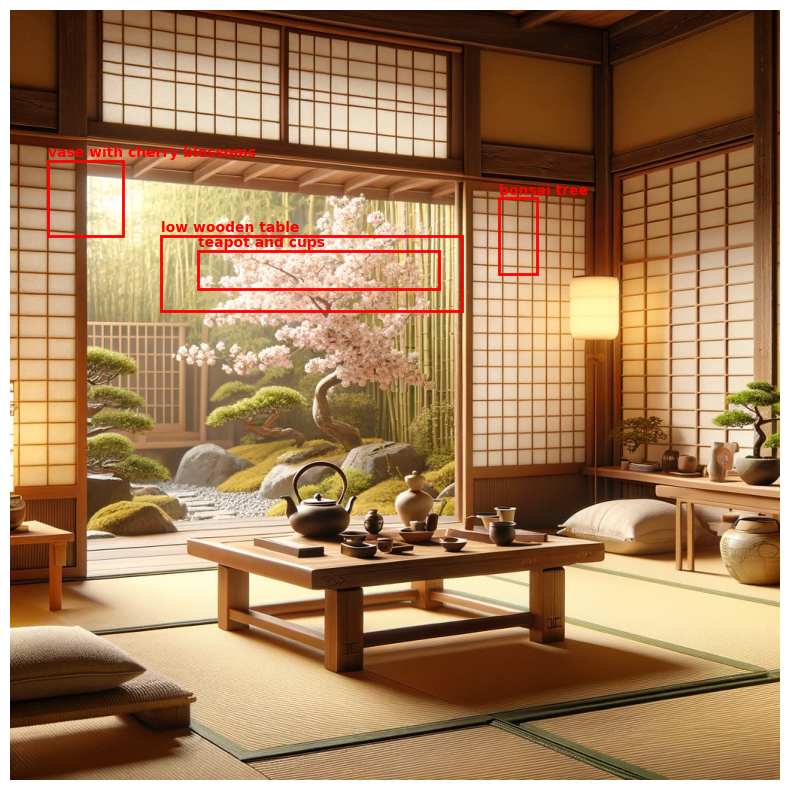

In [102]:
import json
from PIL import Image
import matplotlib.pyplot as plt

# Function to parse the JSON response and extract labels and positions
def parse_list_boxes(response):
    try:
        # Parse the response string into JSON
        response_json = json.loads(response)
        
        # Extract labels and positions for each object
        result = []
        for obj in response_json.get("objects", []):
            if "position" in obj and "label" in obj:
                label = obj["label"]
                position = obj["position"]
                result.append((label, position))  # Tuple of (label, position)
        return result
    except json.JSONDecodeError:
        raise ValueError("Response is not valid JSON")

# Function to plot bounding boxes on the image
def plot_bounding_boxes(image, noun_phrases_and_positions):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for label, position in noun_phrases_and_positions:
        xmin, ymin, xmax, ymax = position
        # Draw the bounding box
        plt.gca().add_patch(
            plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                          edgecolor="red", facecolor="none", lw=2)
        )
        # Add the label near the top-left corner of the box
        plt.text(xmin, ymin - 5, label, color="red", fontsize=10, fontweight="bold")
    plt.axis("off")
    plt.show()

# Sample JSON response
response = """
{
  "objects": [
    {
      "label": "low wooden table",
      "position": [200, 300, 600, 400],
      "confidence": 0.95
    },
    {
      "label": "teapot and cups",
      "position": [250, 320, 570, 370],
      "confidence": 0.90
    },
    {
      "label": "bonsai tree",
      "position": [650, 250, 700, 350],
      "confidence": 0.92
    },
    {
      "label": "vase with cherry blossoms",
      "position": [50, 200, 150, 300],
      "confidence": 0.88
    }
  ]
}
"""

# Parse the response and extract labels and bounding boxes
boxes = parse_list_boxes(response)

# Plot the bounding boxes on the image
img_path = "images/test3.jpg"  # Replace with your image path
plot_bounding_boxes(Image.open(img_path), noun_phrases_and_positions=boxes)


# VLM (2): GEMINI


In [103]:
# @title Plotting Utils
import json
import random
import io
from PIL import Image, ImageDraw
from PIL import ImageColor


additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def plot_bounding_boxes(im, noun_phrases_and_positions):
    """
    Plots bounding boxes on an image with markers for each noun phrase, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        noun_phrases_and_positions: A list of tuples containing the noun phrases
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Iterate over the noun phrases and their positions
    for i, (noun_phrase, (y1, x1, y2, x2)) in enumerate(
        noun_phrases_and_positions):
        # Select a color from the list
        color = colors[i % len(colors)]

        # Convert normalized coordinates to absolute coordinates
        abs_x1 = int(x1/1000 * width)
        abs_y1 = int(y1/1000 * height)
        abs_x2 = int(x2/1000 * width)
        abs_y2 = int(y2/1000 * height)

        # Draw the bounding box
        draw.rectangle(
            ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
        )

        # Draw the text
        draw.text((abs_x1 + 8, abs_y1 + 6), noun_phrase, fill=color)

    # Display the image
    img.show()

# @title Parsing utils
def parse_list_boxes(text):
  result = []
  for line in text.strip().splitlines():
    # Extract the numbers from the line, remove brackets and split by comma
    try:
      numbers = line.split('[')[1].split(']')[0].split(',')
    except:
      numbers =  line.split('- ')[1].split(',')

    # Convert the numbers to integers and append to the result
    result.append([int(num.strip()) for num in numbers])

  return result

def parse_list_boxes_with_label(text):
  text = text.split("```\n")[0]
  return json.loads(text.strip("```").strip("python").strip("json").replace("'", '"').replace('\n', '').replace(',}', '}'))



In [104]:
%matplotlib inline
import os
import google.generativeai as genai
from PIL import Image
import requests
import io

In [107]:
im = Image.open(img)

genai.configure(api_key=os.environ.get("GEMINI_API_KEY"))
model = genai.GenerativeModel("gemini-1.5-pro")

response = model.generate_content([
    im,
    (
        "Detect if there is a teapot in the image and reutrn its coordinates as a list in the format '[ymin,xmin, ymax, xmax]'. Just output the list.\n "
    ),
])
response.resolve()
print(response.text)

[610, 355, 693, 446]


(1024, 1024)


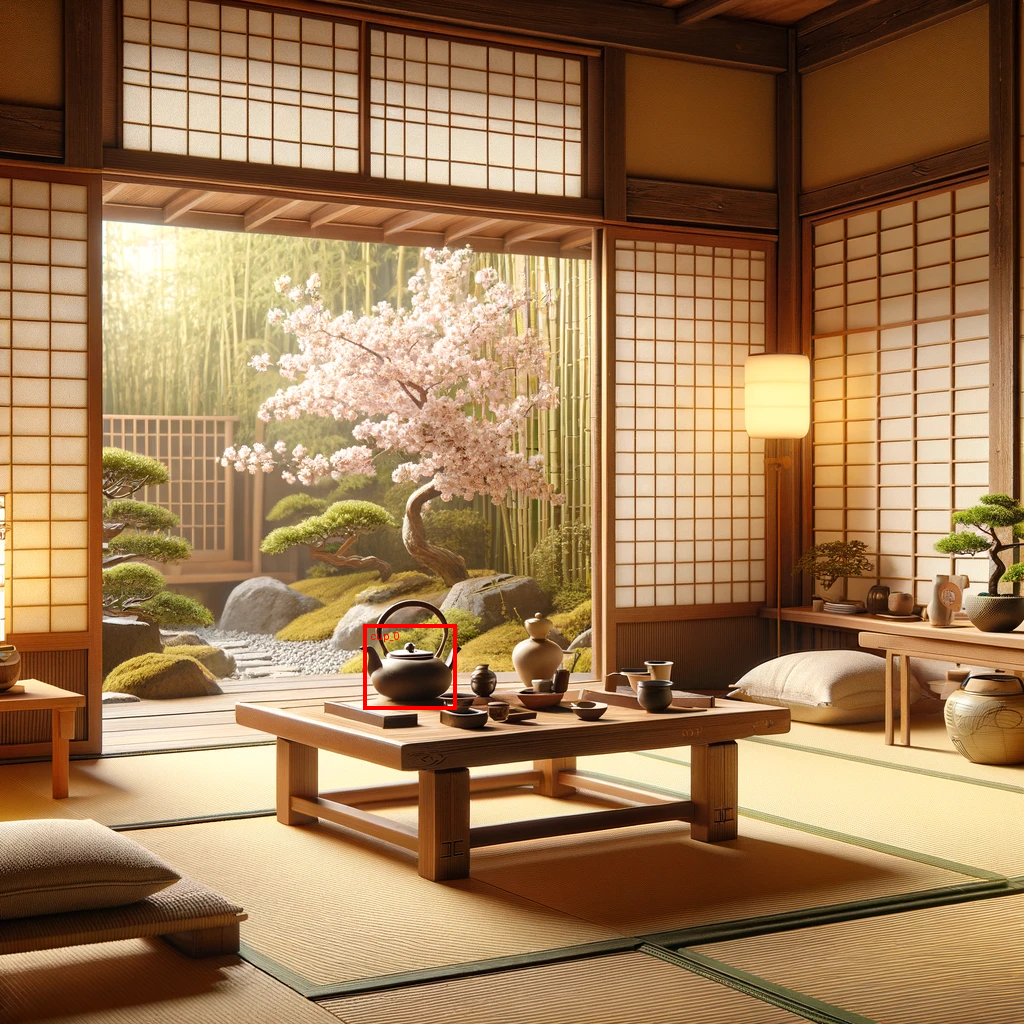

In [108]:
boxes= parse_list_boxes(response.text)
boxes = {f'cup_{i}': x for i, x in enumerate(boxes)}
plot_bounding_boxes(im, noun_phrases_and_positions=list(boxes.items()))